**У меня были проблемы с обучением модели, я не смог сделать это нормально. Были очень большие лоссы и модель не обучалась. Я пробовал найти баг, но не смог, поэтому решил отправить то, что есть**

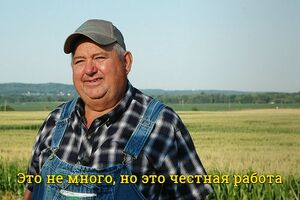

### 1. Подключаем диск

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Импортим все, что нужно

In [2]:
import torch
from torch import nn
from itertools import chain
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
plt.rcParams["figure.figsize"] = (12, 12)

### 3. Загружаем картинки, создаем датасет

In [3]:
photos_dir = '/content/drive/MyDrive/CycleGAN/images/photo_jpg'
monet_images_dir = '/content/drive/MyDrive/CycleGAN/images/monet_jpg'

for root, _, files in os.walk(photos_dir):
  photos = list(map(lambda filename: os.path.join(root, filename), files))

for root, _, files in os.walk(monet_images_dir):
  monet_images = list(map(lambda filename: os.path.join(root, filename), files))

In [4]:
def load_image(image_path):
  image = Image.open(image_path)
  return image

def image_to_tensor(image):
  return transforms.PILToTensor()(image).float()

def tensor_to_image(tensor):
  return transforms.ToPILImage()(tensor)

def show_images(photo, monet_image, result=None):
  fig, axs = plt.subplots(ncols=2 if result is None else 3)

  axs[0].set_title('photo')
  axs[0].imshow(photo)

  axs[1].set_title('monet image')
  axs[1].imshow(monet_image)

  if result is not None:
    axs[2].set_title('result image')
    axs[2].imshow(result)
  plt.show()

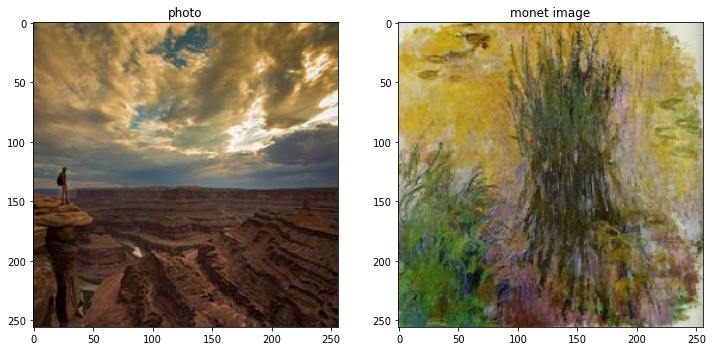

In [5]:
index = random.randint(0, 250)

photo = load_image(photos[index])
monet_image = load_image(monet_images[index])

show_images(photo, monet_image)

In [6]:
class MonetDataset(Dataset):
  def __init__(self, photos_paths, monets_paths, samples_count):
    super().__init__()
    self.photos_paths = photos_paths
    self.monets_paths = monets_paths
    self.samples_count = samples_count
  
  def __len__(self):
    return self.samples_count
  
  def __getitem__(self, idx):
    photo_index = random.randint(0, len(self.photos_paths)-1)
    photo = image_to_tensor(load_image(self.photos_paths[photo_index]))
    monet_index = random.randint(0, len(self.monets_paths)-1)
    monet_image = image_to_tensor(load_image(self.monets_paths[monet_index]))
    return photo, monet_image

In [7]:
BATCH_SIZE = 1
SAMPLES_COUNT = 100
dataset = MonetDataset(photos, monet_images, SAMPLES_COUNT)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### 4. Пишем модель

In [8]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.LeakyReLU(0.2),
      nn.InstanceNorm2d(out_channels)
  )

class ResidualBlock(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        conv_block(in_channels=num_features, out_channels=num_features, kernel_size=3, stride=1),
        nn.ReflectionPad2d(1),
        conv_block(in_channels=num_features, out_channels=num_features, kernel_size=3, stride=1)
    )
  
  def forward(self, input):
    return input + self.layers(input)

def upsample_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, out_padding=1):
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=out_padding),
        nn.LeakyReLU(0.2),
        nn.InstanceNorm2d(out_channels)
  )

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder_block = nn.Sequential(
        nn.ReflectionPad2d(3),
        conv_block(in_channels=3, out_channels=64, kernel_size=7, stride=1),
        conv_block(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        conv_block(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    )

    self.transformer_block = nn.Sequential(
        ResidualBlock(256),
        ResidualBlock(256),
        # nn.Dropout(0.5),
        ResidualBlock(256),
        ResidualBlock(256),
        # nn.Dropout(0.5),
        ResidualBlock(256),
        ResidualBlock(256)
    )

    self.decoder_block = nn.Sequential(
        upsample_block(in_channels=256, out_channels=128, stride=2, padding=1),
        upsample_block(in_channels=128, out_channels=64, stride=2, padding=1),
        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, 7)
    )

    self.activation = nn.Tanh()

  def forward(self, image):
    image = self.encoder_block(image)
    image = self.transformer_block(image)
    image = self.decoder_block(image)
    output = self.activation(image)
    return output

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        conv_block(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
        conv_block(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
        conv_block(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
        conv_block(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
        conv_block(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
    )

  def forward(self, input):
    output = self.layers(input)
    return output

In [11]:
def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(module.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(module.weight, 1.0, 0.02)
        torch.nn.init.zeros_(module.bias)

In [12]:
save_paths = {
              'gen_a2b': '/content/drive/MyDrive/CycleGAN/models/generator_a2b.pth',
              'gen_b2a': '/content/drive/MyDrive/CycleGAN/models/generator_b2a.pth',
              'disc_a': '/content/drive/MyDrive/CycleGAN/models/discriminator_a.pth',
              'disc_b': '/content/drive/MyDrive/CycleGAN/models/discriminator_b.pth'
              }

def save_models():
  torch.save(generator_a2b.state_dict(), save_paths['gen_a2b'])
  torch.save(generator_b2a.state_dict(), save_paths['gen_b2a'])
  torch.save(discriminator_a.state_dict(), save_paths['disc_a'])
  torch.save(discriminator_b.state_dict(), save_paths['disc_b'])

### 5. Обучаем модель

In [13]:
device = torch.device('cuda:0' if  torch.cuda.is_available() else 'cpu')

generator_a2b = Generator().to(device)
generator_a2b.apply(weights_init)

generator_b2a = Generator().to(device)
generator_b2a.apply(weights_init)

discriminator_a = Discriminator().to(device)
discriminator_a.apply(weights_init)

discriminator_b = Discriminator().to(device)
discriminator_b.apply(weights_init)

cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()
adversarial_loss = nn.MSELoss()

gen_a2b_optimizer = torch.optim.Adam(generator_a2b.parameters(), betas=(0.5, 0.999))
gen_b2a_optimizer = torch.optim.Adam(generator_b2a.parameters(), betas=(0.5, 0.999))
disc_a_optimizer = torch.optim.Adam(discriminator_a.parameters(), betas=(0.5, 0.999))
disc_b_optimizer = torch.optim.Adam(discriminator_b.parameters(), betas=(0.5, 0.999))

gen_a2b_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_a2b_optimizer, gamma=0.9)
gen_b2a_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_b2a_optimizer, gamma=0.9)
disc_a_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(disc_a_optimizer, gamma=0.9)
disc_b_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(disc_b_optimizer, gamma=0.9)

epochs = 10
identity_loss_weight = 5
cycle_loss_weight = 10
best_loss_value = float('inf')

In [14]:
# где-то здесь, я думаю, и есть баг, но я его не нашел(
for epoch in tqdm(range(1, epochs + 1)):
  loss_value  = 0
  for real_a, real_b in tqdm(loader):
    real_a = real_a.to(device)
    real_b = real_b.to(device)

    real_labels = torch.full((BATCH_SIZE, 1, 30, 30), 1, dtype=torch.float).detach().to(device)
    fake_labels = torch.full((BATCH_SIZE, 1, 30, 30), 0, dtype=torch.float).detach().to(device)


    ########################################
    # update generators: A -> B and B -> A #
    ########################################
    gen_a2b_optimizer.zero_grad()
    gen_b2a_optimizer.zero_grad()

    identity_a = generator_b2a(real_a)
    identity_loss_a = identity_loss(identity_a, real_a) * identity_loss_weight
    identity_b = generator_a2b(real_b)
    identity_loss_b = identity_loss(identity_b, real_b) * identity_loss_weight

    fake_a = generator_b2a(real_b)
    fake_out_a = discriminator_a(fake_a)
    adversarial_loss_b2a = adversarial_loss(fake_out_a, real_labels)
    fake_b = generator_a2b(real_a)
    fake_out_b = discriminator_b(fake_b)
    adversarial_loss_a2b = adversarial_loss(fake_out_b, real_labels)

    rec_a = generator_b2a(fake_b)
    cycle_loss_a = cycle_loss(rec_a, real_a) * cycle_loss_weight
    rec_b = generator_a2b(fake_a)
    cycle_loss_b = cycle_loss(rec_b, real_b) * cycle_loss_weight

    generator_loss = sum([
                identity_loss_a, identity_loss_b,
                adversarial_loss_b2a, adversarial_loss_a2b,
                cycle_loss_a, cycle_loss_b
                ])
    generator_loss.backward()
    gen_a2b_optimizer.step()
    gen_b2a_optimizer.step()
    ##########################
    # update discriminator A #
    ##########################

    disc_a_optimizer.zero_grad()

    real_out_a = discriminator_a(real_a)
    disc_a_real_loss = adversarial_loss(real_out_a, real_labels)
    # fake_a = generator_b2a(real_b).detach()
    fake_out_a = discriminator_a(fake_a.detach())
    disc_a_fake_loss = adversarial_loss(fake_out_a, fake_labels)

    disc_a_loss = (disc_a_real_loss + disc_a_fake_loss) / 2
    disc_a_loss.backward()
    disc_a_optimizer.step()

    ##########################
    # update discriminator B #
    ##########################

    disc_b_optimizer.zero_grad()

    real_out_b = discriminator_b(real_b)
    disc_b_real_loss = adversarial_loss(real_out_b, real_labels)
    # fake_b = generator_a2b(real_a).detach()
    fake_out_b = discriminator_b(fake_b.detach())
    disc_b_fake_loss = adversarial_loss(fake_out_b, fake_labels)

    disc_b_loss = (disc_b_real_loss + disc_b_fake_loss) / 2
    disc_b_loss.backward()
    disc_b_optimizer.step()

    loss_value = loss_value + generator_loss.item()

    # if epochs % 2 == 0:
    #   photo = tensor_to_image(real_a)
    #   monet_image = tensor_to_image(real_b)
    #   result_image = tensor_to_image(fake_b.detach())
    #   show_images(photo, monet_image, result_image)

  loss_value /= len(loader)
  if loss_value < best_loss_value:
    best_loss_value = loss_value
    save_models()
  print(f'A identity loss: {identity_loss_a.item()}')
  print(f'B identity loss: {identity_loss_b.item()}')
  print(f'A -> B adversarial loss: {adversarial_loss_a2b.item()}')
  print(f'B -> A adversarial loss: {adversarial_loss_b2a.item()}')
  print(f'A cycle loss: {cycle_loss_a.item()}')
  print(f'B cycle loss: {cycle_loss_b.item()}')
  print(f'Discriminator A loss: {disc_a_loss.item()}')
  print(f'Discriminator B loss: {disc_b_loss.item()}')
  # print(f'best loss: {best_loss_value:.4f}')
  gen_a2b_lr_scheduler.step()
  gen_b2a_lr_scheduler.step()
  disc_a_lr_scheduler.step()
  disc_b_lr_scheduler.step()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 486.2525634765625
B identity loss: 691.465087890625
A -> B adversarial loss: 1.999998927116394
B -> A adversarial loss: 2.0
A cycle loss: 971.7373657226562
B cycle loss: 1382.398193359375
Discriminator A loss: 1.5
Discriminator B loss: 1.4999992847442627


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 633.687744140625
B identity loss: 628.6868896484375
A -> B adversarial loss: 1.999999761581421
B -> A adversarial loss: 2.0
A cycle loss: 1267.0042724609375
B cycle loss: 1256.71630859375
Discriminator A loss: 1.5000001192092896
Discriminator B loss: 1.4999998807907104


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 240.38427734375
B identity loss: 597.9586181640625
A -> B adversarial loss: 2.0
B -> A adversarial loss: 2.0
A cycle loss: 481.28826904296875
B cycle loss: 1194.19677734375
Discriminator A loss: 1.5
Discriminator B loss: 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 320.5158996582031
B identity loss: 623.472900390625
A -> B adversarial loss: 1.9999998807907104
B -> A adversarial loss: 2.0
A cycle loss: 640.8666381835938
B cycle loss: 1246.3876953125
Discriminator A loss: 1.5
Discriminator B loss: 1.499999761581421


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 544.2615966796875
B identity loss: 848.4533081054688
A -> B adversarial loss: 2.0
B -> A adversarial loss: 2.0
A cycle loss: 1088.0601806640625
B cycle loss: 1696.730712890625
Discriminator A loss: 1.5
Discriminator B loss: 1.499999761581421


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 534.5852661132812
B identity loss: 673.9296875
A -> B adversarial loss: 1.999999761581421
B -> A adversarial loss: 2.000000238418579
A cycle loss: 1069.0205078125
B cycle loss: 1347.546630859375
Discriminator A loss: 1.5
Discriminator B loss: 1.4999998807907104


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 234.75364685058594
B identity loss: 811.7791137695312
A -> B adversarial loss: 1.999998688697815
B -> A adversarial loss: 2.0
A cycle loss: 469.19012451171875
B cycle loss: 1623.35498046875
Discriminator A loss: 1.5
Discriminator B loss: 1.4999990463256836


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 455.7991943359375
B identity loss: 528.9503173828125
A -> B adversarial loss: 2.0
B -> A adversarial loss: 1.999999761581421
A cycle loss: 911.9866943359375
B cycle loss: 1056.9971923828125
Discriminator A loss: 1.5
Discriminator B loss: 1.4999998807907104


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 377.8530578613281
B identity loss: 759.9383544921875
A -> B adversarial loss: 2.000000238418579
B -> A adversarial loss: 2.0
A cycle loss: 755.6604614257812
B cycle loss: 1520.1734619140625
Discriminator A loss: 1.5
Discriminator B loss: 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

A identity loss: 181.0067596435547
B identity loss: 633.4703979492188
A -> B adversarial loss: 2.000000238418579
B -> A adversarial loss: 2.000000238418579
A cycle loss: 361.7119140625
B cycle loss: 1266.55322265625
Discriminator A loss: 1.5
Discriminator B loss: 1.5


### 6. Посмотрим, что там вообще получилось

In [15]:
photo_path = random.choice(photos)
monet_img_path = random.choice(monet_images)

photo_img = load_image(photo_path)
monet_img = load_image(monet_img_path)

photo_tensor = image_to_tensor(photo_img)
monet_tensor = image_to_tensor(monet_img)

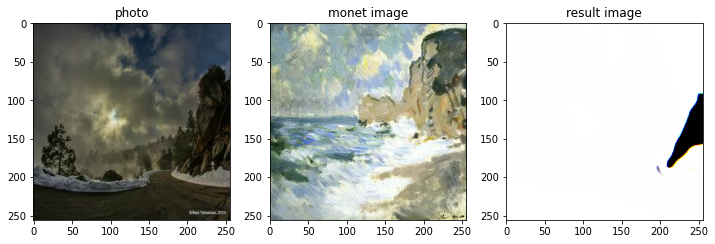

In [16]:
res = generator_a2b(photo_tensor.to(device)).detach().cpu()
res = transforms.ToPILImage()(res)
show_images(photo_img, monet_img, res)